In [6]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import csv

from gensim.models import Word2Vec

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from time import time

In [2]:
# Read the h-indices
df = pd.read_csv('../Data/train.csv', dtype={'author': np.int64, 'hindex': np.float32})

# Load the graph
G = nx.read_edgelist('../Data/coauthorship.edgelist', delimiter=' ', nodetype=int)

In [217]:
subnodes = [k for i,k in enumerate(G) if i < 20000]
subG = G.subgraph(subnodes)
#nx.write_edgelist(subG, '../Data/50000_coauthorship_tab.edgelist', delimiter='\t', data = False)

In [3]:
# Computes some graph properties
core_num = nx.core_number(G)
print("Core number done")
average_neighbor_deg = nx.average_neighbor_degree(G)
print("Average neighbor degree done")
eigenvector_cen = nx.eigenvector_centrality(G)
print("Eigenvector centrality done")
page_rank = nx.pagerank(G)
print("Pagerank done")

Core number done
Average neighbor degree done
Eigenvector centrality done
Pagerank done


In [22]:
# Loads basic text features

best_word = {}
with open('../Data/author_best.csv', encoding='utf-8') as f:
    for row in csv.reader(f):
        best_word[int(row[0])] = float(row[1])

sci_words = {}
with open('../Data/score.csv', encoding='utf-8') as f:
    for row in csv.reader(f):
        sci_words[int(row[0])] = float(row[1])

nb_papers = {}
with open('../Data/nb_articles.csv', encoding='utf-8') as f:
    for row in csv.reader(f):
        nb_papers[int(row[0])] = float(row[1])

Let's take a quick look at the data

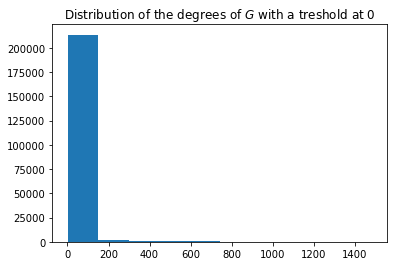

In [3]:
treshold = 0

# Degree distribution
l = []
for node in G:
    if G.degree(node) > treshold:
        l.append(G.degree(node))

plt.hist(l)
plt.title("Distribution of the degrees of $G$ with a treshold at {}".format(treshold))
print()

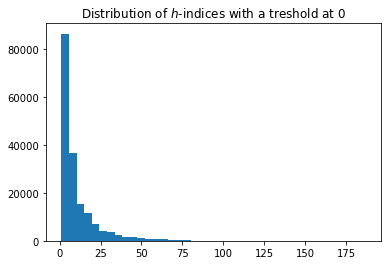

In [12]:
treshold = 0

# Distribution of h-indices
hindex = df['hindex']
plt.hist(hindex[hindex > treshold], bins = 40)
plt.title("Distribution of $h$-indices with a treshold at {}".format(treshold))
print()

# Learning

Here we attempt to predict the $h$-indices based only on properties of the graph

We split the dataframe into a dataframe for training and a dataframe for testing

In [11]:
# Fraction of samples in the training set
train_frac = 0.7
# Split the dataframe into train and test dataframes
df_train = df.sample(frac = train_frac)
df_test = df.drop(df_train.index)

### Baseline

We try to reproduce the score of the baseline using only the training dataset (because we do not have the answers for the testing dataset).

In [98]:
# Builds the feature vectors and target vector from the dataframe
# Here we reproduce the features of the baseline
def featvecs_baseline(df):
    n = df.shape[0]
    X = np.zeros((n,2))
    y = np.zeros(n)
    for i, x in zip(range(n), df.iterrows()):
        _, row = x
        X[i,0] = G.degree(row['author'])
        X[i,1] = core_num[row['author']]
        y[i] = row['hindex']
    return X,y

In [99]:
# Fitting a lasso model like in the baseline

X_train, y_train = featvecs_baseline(df_train)
print("Training features built")

X_test, y_test = featvecs_baseline(df_test)
print("Testing features built\n")

reg = Lasso(alpha = 0.1)
reg.fit(X_train, y_train)
print("Model fitted\n")

y_pred = reg.predict(X_test)
print("MSE: {:.4}".format(mean_squared_error(y_pred, y_test)))

Training features built
Testing features built

Model fitted

MSE: 128.6


### Experimental Area

Here is for experimenting with different kinds of graph-based features.

Let's try to add different powers of the degrees. In particular, we expect a dependance with the square root of the degree.

In [100]:
# Builds the feature vectors and target vector from the dataframe

def featvecs_experimental(df, powers):
    n = df.shape[0]
    X = np.zeros((n,len(powers)))
    y = np.zeros(n)
    for i, x in enumerate(df.iterrows()):
        _, row = x
        deg = G.degree(row['author'])
        cn = core_num[row['author']]
        for j, power in enumerate(powers):
            X[i,j] = deg ** power
            #X[i,j + len(powers)] = cn ** power
        y[i] = row['hindex']
    return X,y

In [101]:
# Fitting a lasso model like in the baseline

X_train, y_train = featvecs_nn(df_train)
print("Training features built")

X_test, y_test = featvecs_nn(df_test)
print("Testing features built")

reg = Lasso(alpha = 0.1, max_iter = 1e5)
reg.fit(X_train, y_train)
print("Model fitted\n")

y_pred = reg.predict(X_test)
print("MSE: {:.4}".format(mean_squared_error(y_pred, y_test)))

Training features built
Testing features built
Model fitted

MSE: 112.5


# Fitting the basic graph features with a lasso

We use different graph node features as input for a lasso.

In [238]:
# Builds the feature vectors and target vector from the dataframe

n_feat = 5

def featvecs(df):
    
    n = df.shape[0]
    X = np.zeros((n, n_feat))
    y = np.zeros((n, 1))
    
    for i, x in enumerate(df.iterrows()):
        
        _, row = x
        node = row['author']
        
        X[i, 0] = G.degree(node) ** 0.2
        X[i, 1] = core_num[node]
        X[i, 2] = average_neighbor_deg[node]
        X[i, 3] = eigenvector_cen[node]
        X[i, 4] = page_rank[node]
        
        y[i] = row['hindex']
    
    return X,y

In [239]:
# Fitting a lasso model

X_train, y_train = featvecs(df_train)
print("Training features built")

X_test, y_test = featvecs(df_test)
print("Testing features built")

reg = Lasso(alpha = 0.1, max_iter = 1e5)
reg.fit(X_train, y_train)
print("Model fitted\n")

y_pred = reg.predict(X_test)
print("MSE: {:.4}".format(mean_squared_error(y_pred, y_test)))

Training features built
Testing features built
Model fitted

MSE: 114.2


##### Feature normalization

One big problem here is that the features are on very different orders of magnitude. Normalizing the features does not significantly improve the performance of the model, but help compare features the lasso coefficients.

In [241]:
# Normalizing features (assumes that X_train is much larger than X_test)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [242]:
# Training the lasso model
reg = Lasso(alpha = 0.1, max_iter = 1e5)
reg.fit(X_train, y_train)
print("Model fitted\n")

# Evaluating the model
y_pred = reg.predict(X_test)
print("MSE: {:.4}".format(mean_squared_error(y_pred, y_test)))

Model fitted

MSE: 111.2


##### Taking into account the distribution of $h$-indices

If we take a look at the distribution of the $h$-indices in the predicted vector, we see that it is very far from the distribution in the target vector of both the train and test data. In fact, there is a significant share of the samples of the training data that have an $h$-index smaller than the smallest predicted h-index.

In [244]:
print("Smallest predicted h-index: {:.3}".format(min(y_pred)))
print("Percentage of h-indices in the training set below the smallest predicted value: {:.2%}".format(len(y_train[y_train < min(y_pred)]) / len(y_train)))

Smallest predicted h-index: 3.0
Percentage of h-indices in the training set below the smallest predicted value: 34.72%


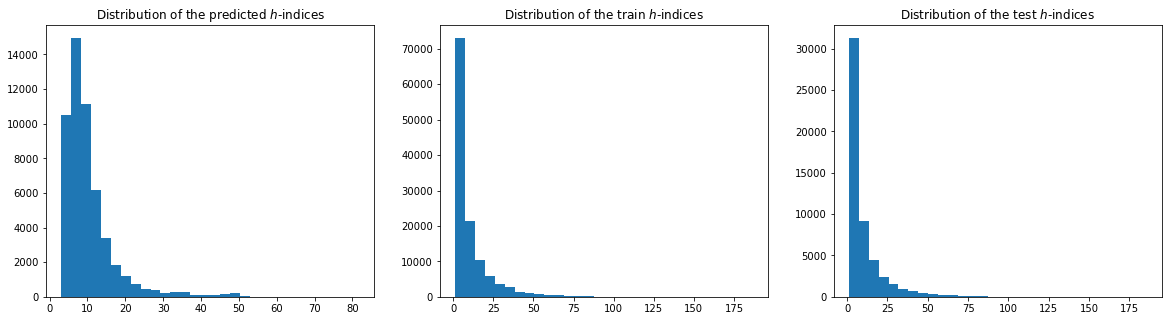

In [245]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

ax[0].hist(y_pred, bins = 30)
ax[0].set_title("Distribution of the predicted $h$-indices")
ax[1].hist(y_train, bins = 30)
ax[1].set_title("Distribution of the train $h$-indices")
ax[2].hist(y_test, bins = 30)
ax[2].set_title("Distribution of the test $h$-indices")
print()

What we can do to fix that is create the mapping that takes the distribution of the prediction on the training set onto the distribution of the traget of the training set, and apply it to the prediction on the testing set.

In [246]:
a = np.array([2,9,8,7,1])
idxl = np.argsort(a)

# get the list of indices in the sorted list
# This list is such that idx[i] is the index of a[i] in the sorted list
idx = np.zeros(5)
for i,ii in enumerate(idxl):
    idx[ii] = i

In [247]:
# Training the lasso model
reg = Lasso(alpha = 0.1, max_iter = 1e5)
reg.fit(X_train, y_train)
print("Model fitted\n")

train_pred = reg.predict(X_train)

idxx = np.argsort(train_pred)
# This list is such that idx[i] is the index of a[i] in the sorted list
idx = np.zeros(len(idxx), dtype = int)
for i,ii in enumerate(idxx):
    idx[ii] = int(i)

sorted_y_train = np.sort(y_train)

train_pred_2 = sorted_y_train[idx]

# Evaluating the model on the train set
print("MSE on train: {:.4}".format(mean_squared_error(train_pred, y_train)))
print("MSE on train: {:.4}".format(mean_squared_error(train_pred_2, y_train)))

Model fitted

MSE on train: 108.7
MSE on train: 315.9


In [248]:
np.intersect1d(np.where(train_pred > 50)[0], np.where(y_train > 100)[0])

array([ 36040,  63031, 108887], dtype=int64)

### Graph features for a neural network

In [26]:
# Builds the feature vectors

X_train, y_train = featvecs_node2vec(df_train)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
print("Training features built")

# Normalize X_train
#X_train = nn.functional.normalize(X_train, dim = 0)

X_test, y_test = featvecs_node2vec(df_test)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
print("Testing features built")

# Normalize X_test
#X_test = nn.functional.normalize(X_test, dim = 0)

Training features built
Testing features built


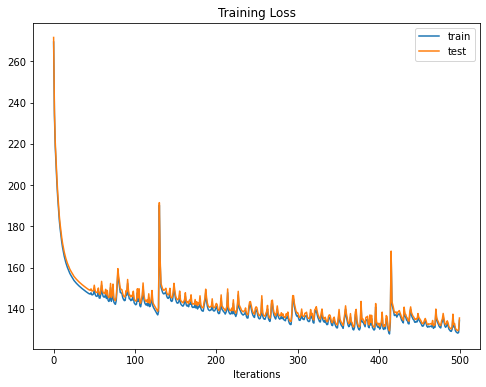

127.8


In [28]:
model = nn.Sequential(nn.Linear(n_feat, 40), nn.Tanh(), nn.Linear(40, 1))

loss_function = nn.MSELoss()
other_loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

train_losses = []
test_losses = []

for epoch in range(500):
    
    # Update test loss
    output_test = model(X_test)
    test_losses.append(other_loss(output_test, y_test).item())
    
    # Optimization step
    output = model.forward(X_train)
    loss = loss_function(output, y_train)
    optimizer.zero_grad() #required since pytorch accumulates the gradients
    loss.backward() #backpropagation step
    optimizer.step() #update the parameters
    
    # Update train loss
    train_losses.append(loss.item())
    
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(train_losses, label = 'train')
ax.plot(test_losses, label = 'test')
ax.set_title("Training Loss")
ax.set_xlabel("Iterations")
plt.legend()
plt.show()

print("{:.4}".format(min(train_losses)))

# Using the node2vec embedding as grap features

Here we try to use the node2vec embedding of nodes as a node feature for a lasso model.

In [12]:
model = Word2Vec.load("../Word2Vec_models/model1.model")
n_dim = len(model.wv[str(2336566022)])
embedding = np.zeros((G.number_of_nodes(), n_dim))
for idx, node in enumerate(G.nodes()):
    embedding[idx, :] = model.wv[str(node)]

In [23]:
# Builds the feature vectors and target vector from the dataframe

other_feat = 8
n_feat = n_dim + other_feat

def featvecs_node2vec(df):
    
    n = df.shape[0]
    X = np.zeros((n, n_feat))
    y = np.zeros((n, 1))
    
    idx = list(G.nodes())
    rev_idx = {idx[i]: i for i in range(len(idx))}
    
    for i, x in enumerate(df.iterrows()):
        
        _, row = x
        node = row['author']
        
        # Standard node features
        X[i, 0] = G.degree(node) ** 0.2
        X[i, 1] = core_num[node]
        X[i, 2] = average_neighbor_deg[node]
        X[i, 3] = eigenvector_cen[node]
        X[i, 4] = page_rank[node]
        X[i, 5] = best_word[node]
        X[i, 6] = sci_words[node]
        X[i, 7] = nb_papers[node]
        
        # Node2Vec features
        X[i, other_feat:] = embedding[rev_idx[node], :]
        
        y[i] = row['hindex']
    
    return X,y

In [24]:
# Building train features
X_train, y_train = featvecs_node2vec(df_train)
print("Training features built")

# Building test features
X_test, y_test = featvecs_node2vec(df_test)
print("Testing features built")

# We do not normalize the node2vec embedding
scaler = StandardScaler().fit(X_train[:,:-n_dim])
X_train[:,:-n_dim] = scaler.transform(X_train[:,:-n_dim])
X_test[:,:-n_dim] = scaler.transform(X_test[:,:-n_dim])

# The lasso model
reg = Lasso(alpha = 0.1, max_iter = 1e5)
reg.fit(X_train, y_train)
print("Model fitted\n")

# Evaluating the model
y_pred = reg.predict(X_test)
print("MSE: {:.4}".format(mean_squared_error(y_pred, y_test)))

Training features built
Testing features built
Model fitted

MSE: 97.35


### Hard limit

In [25]:
reg.coef_

array([ 2.62857379e+00,  4.18398826e-01,  8.65586203e-01,  0.00000000e+00,
        2.91866777e+00,  2.57370394e+00, -1.76176913e-03,  1.91278106e+00,
        4.48871243e-02,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  2.55213083e-01,
        0.00000000e+00,  9.91707274e-02, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.64488167e-02,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  9.59502929e-02, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.74912695e-01,
        6.17557410e-02, -0.00000000e+00,  0.00000000e+00, -1.19751242e-01,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -2.66330793e-01, -2.09791782e-01,
       -0.00000000e+00,  